#**Factors Contributing to SF Taxi Fare Pricing**

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


San Francisco taxi trip data 2023-2025. Data & data dictionary available at https://data.sfgov.org/Transportation/Taxi-Trips/m8hk-2ipk/about_data

In [12]:
taxi_data = pd.read_csv('/content/Taxi_Trip_Data.csv', on_bad_lines= 'warn', engine='python')


###**Data Cleaning and Formating**
Data that indicates error or far exceeds the normal bounds of a taxi trip are excluded.

For instance trips with:
*   Distance of zero
*   Fares over $1000
*   Trips exceeding 2 hours

In [13]:
print('Original Dataset: ' + str(len(taxi_data)) + ' trips')

Original Dataset: 4129083 trips


In [14]:
format_string = "%Y/%m/%d %I:%M:%S %p"
taxi_data['start_time_local'] = pd.to_datetime(taxi_data['start_time_local'], format=format_string)
taxi_data['end_time_local'] = pd.to_datetime(taxi_data['end_time_local'], format=format_string)

taxi_data["total_fare_amount"] = (
    taxi_data["total_fare_amount"].astype(str)
      .str.replace(",", "", regex=False)
      .str.replace("$", "", regex=False)
      .str.strip()
)

taxi_data['total_fare_amount'] = pd.to_numeric(taxi_data['total_fare_amount'], errors='coerce')

taxi_data["trip_distance_meters"] = (
    taxi_data["trip_distance_meters"].astype(str)
      .str.replace(",", "", regex=False)
      .str.strip()
)
taxi_data['trip_distance_meters'] = pd.to_numeric(taxi_data['trip_distance_meters'], errors='coerce')


taxi_data['trip_duration_ms'] = (
    pd.to_datetime(taxi_data['end_time_local']) - pd.to_datetime(taxi_data['start_time_local'])
).dt.total_seconds() * 1000

taxi_data['trip_duration_ms'].dropna()
taxi_data['trip_duration_ms'] = pd.to_numeric(taxi_data['trip_duration_ms'], errors='coerce')
taxi_data = taxi_data[taxi_data['trip_duration_ms'] > 0]



fare_dist_cleaned_df = taxi_data[['total_fare_amount', 'trip_distance_meters']].dropna()

taxi_data_complete = taxi_data
taxi_data = taxi_data[
    (taxi_data['total_fare_amount'] > 0) &
    (taxi_data['total_fare_amount'] < 1000) &
    (taxi_data['trip_distance_meters'] > 0) &
    (taxi_data['trip_distance_meters'] < 100000) &
    (taxi_data['trip_duration_ms'] > 0) &
    (taxi_data['trip_duration_ms'] < 7200000)
]

In [15]:
print('Dataset Summary:')
print("_"*60)
print('Total Trips Loaded: ', str(len(taxi_data)), " trips")
print("Date Range: ", {taxi_data['start_time_local'].min()}, "to ", {taxi_data['start_time_local'].max()})
print("_"*60)
print("Fare Summary: ")
print("_"*60)
print(taxi_data['total_fare_amount'].describe())
print("_"*60)
print("Distance Summary: ")
print("_"*60)
print(taxi_data['trip_distance_meters'].describe())

Dataset Summary:
____________________________________________________________
Total Trips Loaded:  3855654  trips
Date Range:  {Timestamp('2022-12-01 00:00:00')} to  {Timestamp('2024-05-31 23:59:51')}
____________________________________________________________
Fare Summary: 
____________________________________________________________
count    3.855654e+06
mean     2.926225e+01
std      2.737747e+01
min      1.000000e-02
25%      1.130000e+01
50%      1.780000e+01
75%      4.632000e+01
max      9.980500e+02
Name: total_fare_amount, dtype: float64
____________________________________________________________
Distance Summary: 
____________________________________________________________
count    3.855654e+06
mean     9.828720e+03
std      1.140923e+04
min      1.000044e+01
25%      2.156060e+03
50%      4.440195e+03
75%      1.818600e+04
max      9.999935e+04
Name: trip_distance_meters, dtype: float64


###**Main Analysis**
The following section examines the relationship between total fare price and trip characteristics, including distance, duration, day of week, and time of day. Scatterplots and correlation measurements are used to gauge the strength and direction of these relationships. To ensure the reflection of typical taxi trips, the analysis revolves around a cleaned dataset, which excludes invalid records, such as negative trip durations. For added context, summary statistics of the complete dataset are also referenced to illustrate how atypical trips, like those exceeding two hours, influence relationships and can obscure patterns in standard rides.

**Relationship Between Distance and Total Fare**

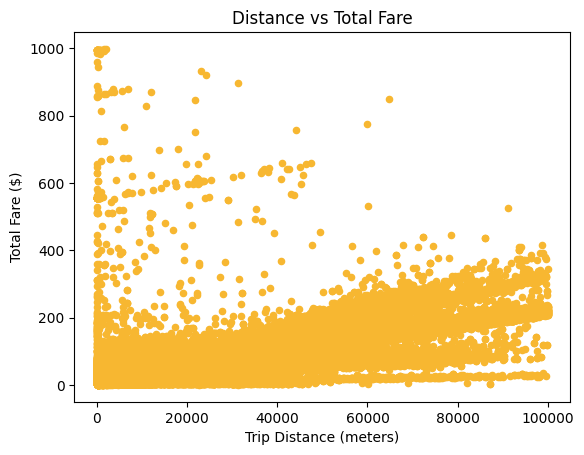

Correlation Coefficient: 0.6665308931836773


In [16]:
taxi_data.plot.scatter(x='trip_distance_meters',y='total_fare_amount', color = '#F7B731')
plt.title('Distance vs Total Fare')
plt.xlabel('Trip Distance (meters)')
plt.ylabel('Total Fare ($)')
plt.show()

fare_distance_corr_coefficient, p_value_1 = pearsonr(fare_dist_cleaned_df['total_fare_amount'], fare_dist_cleaned_df['trip_distance_meters'])
print(f"Correlation Coefficient: {fare_distance_corr_coefficient}")



###**Interpretation of Fare and Distance**

With a correlation coefficient of about 0.67, fare and distance exhibit a strong positive relationship within this dataset. As trip distance increases, fares tend to increase as well, though the variation between the fare and distance suggests additional factors also have a relationship with price.

###Duration and Total Fare

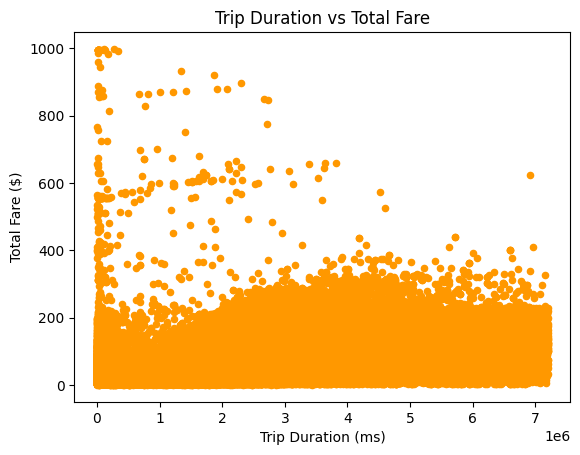

Correlation Coefficient: 0.7865416717384812


In [17]:
taxi_data.plot.scatter(x='trip_duration_ms',y='total_fare_amount', color = '#FF9800')
plt.title('Trip Duration vs Total Fare')
plt.xlabel('Trip Duration (ms)')
plt.ylabel('Total Fare ($)')
plt.show()

fare_duration_corr_coefficient, p_value_2 = pearsonr(taxi_data['total_fare_amount'], taxi_data['trip_duration_ms'])
print(f"Correlation Coefficient: {fare_duration_corr_coefficient}")


###**Interpretation of fare and duration**

With a correlation coefficient of 0.78, fare and distance exhibit a strongly positive relationship within this dataset. As trip time increases, fares tend to increase as well.

It is worth noting that the correlation of fare and duration is higher relative to that of fare and distance. This suggests a stronger relationship between fare and duration.

Without removing any logically plausible ouliers, Correlation Coefficient: 0.3206893668471502
------------------------------------------------------------------------


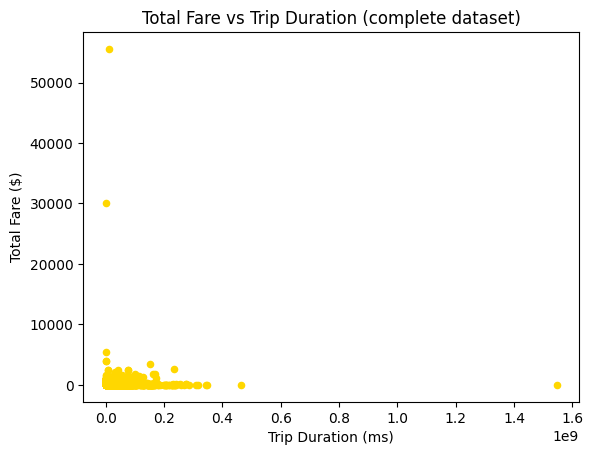

In [18]:
complete_corr = taxi_data_complete[['total_fare_amount', 'trip_duration_ms']].dropna()
fare_duration_corr_complete, p_value_3 = pearsonr(complete_corr['total_fare_amount'], complete_corr['trip_duration_ms'])
print(f"Without removing any logically plausible ouliers, Correlation Coefficient: {fare_duration_corr_complete}")
print("------------------------------------------------------------------------")
complete_corr.plot.scatter(x='trip_duration_ms',y='total_fare_amount', color='#ffd700')
plt.title('Total Fare vs Trip Duration (complete dataset)')
plt.xlabel('Trip Duration (ms)')
plt.ylabel('Total Fare ($)')
plt.show()

###**Interpretation of complete correlation**

Without removing data for trips which are atypical, the relationship between duration and fare price still remains.  
However, to show an accurate relationship between fare and duration, trips with improbable characteristics should be exluded.



Average fare by hour of the day:


,hour_of_day,total_fare_amount
0,0,31.35
1,1,25.38
2,2,21.68
3,3,25.20
4,4,29.34
5,5,26.66
6,6,28.01
7,7,27.61
8,8,27.21
9,9,27.74


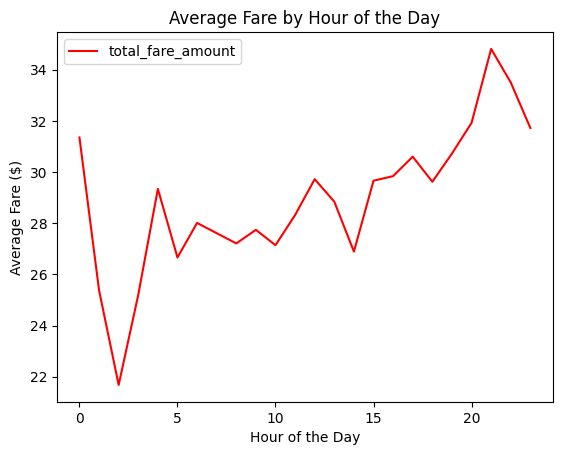

In [19]:
taxi_data = taxi_data[taxi_data['total_fare_amount'] > 0].copy()

taxi_data.loc[:, 'hour_of_day'] = taxi_data['start_time_local'].dt.hour
hourly_fare_data = taxi_data.groupby('hour_of_day')['total_fare_amount'].mean().reset_index()
hourly_fare_data = round(hourly_fare_data, 2)
print("Average fare by hour of the day:")
display(hourly_fare_data)

hourly_fare_data.plot.line(x='hour_of_day', y='total_fare_amount', color='red')
plt.title('Average Fare by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare ($)')
plt.show()

###**Interpretation of Fare by Hour of Day**

A precipitous drop in average fare price can be seen from in the early morning. Without more information an exact cause cannot be known.

The pricing is consistent with consumer behavioral changes that contribute to lower levels of demand at these hours. Similarly, the pricing at peak evening hours support the idea that demand based factors contribute to fare pricing.



Equivalent SQL logic for this query:
```
SELECT
  EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_fare,
  AVG(total_fare_amount) AS avg_fare,
  COUNT(*) AS trip_count
FROM taxi_data
GROUP BY hour_of_fare;
```

###**Day of Week Trip Distribution**

Analysis done in SQL with the following logic:
```
SELECT
  EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS day_of_week,
  AVG(total_fare_amount) AS avg_fare,
  COUNT(*) AS trip_count
FROM taxi_trips
GROUP BY day_of_week
ORDER BY day_of_week;
```

Volume of trips varies by day of week, with weekdays being the most popular, though differences in volume are relatively modest. Average fares are slightly higher on Sunday and Monday relative to the remainder of the week, but no consistent trends relating trip volume and fare can be surmised from the data.

###Conversion of cleaned and aggregated tables into CSV file for use in Tableau.

In [ ]:
hourly_fare_data.to_csv('hourly_fare_data.csv', index=False)
taxi_data.to_csv('taxi_data_aggreagated.csv', index=False)

##**Key Findings**

*  In comparing the effects of distance versus duration, there is some evidence that duration was more consequential for fare pricing.

* Both day of week and time of day components show some variation in pricing, but the differences are marginal.

**Limitations of Study**

*   Data is limited to the scope of San Francisco from 2023 to 2025. The findings of this study are dependent on the unique operating conditions within San Francisco during this period.
* Although the data includes certain app based methods of hailing taxis, broader data is needed to understand how taxi usage is affected by autonomous vehicle and rideshare apps.

**Next Steps**

* Explore more comprehensive datasets that might shed light on impact in taxi trip volume with the introduction of rideshare apps and autonomous vehicles in the city.

* Only a few variables were studied (duration, distance, and time of day), but examining the impact of other variables like base pricing would be a worthwhile next step.